In [1]:
from operator import mod
from tomo2mesh.misc.voxel_processing import TimerGPU, edge_map, modified_autocontrast, get_values_cyl_mask, cylindrical_mask
from tomo2mesh.projects.eaton.recon import recon_binned, recon_all
from tomo2mesh.projects.eaton.params import pixel_size_1X as pixel_size
from tomo2mesh.projects.eaton.rw_utils import read_raw_data_1X, save_path

import cupy as cp
import numpy as np
from tomo2mesh.structures.voids import Voids
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local
from cupyx.scipy import ndimage
from scipy import ndimage as ndimage_cpu
import matplotlib.pyplot as plt



In [2]:
b = 1
projs, theta, center, dark, flat = read_raw_data_1X("89", "7")
t_gpu = TimerGPU("secs")
memory_pool = cp.cuda.MemoryPool()
cp.cuda.set_allocator(memory_pool.malloc)

ntheta, nz, n = projs.shape
projs = np.mean(projs.reshape(ntheta,nz//b,b,n//b,b), axis = (2,4))
projs = np.array(projs, dtype = np.float32)
dark = np.mean(dark.reshape(nz//b, b, n//b, b), axis = (1,3))
flat = np.mean(flat.reshape(nz//b, b, n//b, b), axis = (1,3))
dark = np.array(dark.astype(np.float32), dtype = np.float32)
flat = np.array(flat.astype(np.float32), dtype = np.float32)
theta = np.array(theta, dtype = np.float32)
center = np.float32(center/float(b))

# fbp
t_gpu.tic()
V_ubin = recon_all(projs, theta, center, 32, dark, flat, pixel_size)
Vrec_ubin = V_ubin

# binarize 
voxel_values = get_values_cyl_mask(Vrec_ubin, 1.0)
thresh = np.float32(threshold_otsu(voxel_values))
Vseg_ubin = (Vrec_ubin<thresh).astype(np.uint8)
cylindrical_mask(Vseg_ubin, 1, mask_val = 1)


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [01:33<00:00,  2.60s/it]


In [3]:
# b = 2
# Vrec_ubin_copy = Vrec_ubin.copy()
# Vrec_ubin = Vrec_ubin.reshape(nz//b, b, n//b, b, n//b, b)

# projs, theta, center, dark, flat = read_raw_data_1X("89", "7")
# t_gpu = TimerGPU("secs")
# memory_pool = cp.cuda.MemoryPool()
# cp.cuda.set_allocator(memory_pool.malloc)

# ntheta, nz, n = projs.shape
# projs = np.mean(projs.reshape(ntheta,nz//b,b,n//b,b), axis = (2,4))
# projs = np.array(projs, dtype = np.float32)
# dark = np.mean(dark.reshape(nz//b, b, n//b, b), axis = (1,3))
# flat = np.mean(flat.reshape(nz//b, b, n//b, b), axis = (1,3))
# dark = np.array(dark.astype(np.float32), dtype = np.float32)
# flat = np.array(flat.astype(np.float32), dtype = np.float32)
# theta = np.array(theta, dtype = np.float32)
# center = np.float32(center/float(b))

# # fbp
# t_gpu.tic()
# V_bin = recon_all(projs, theta, center, 32, dark, flat, pixel_size)
# Vrec_bin = V_bin

# # thresholding
# thresh_matrix = threshold_local(Vrec_bin, 3, 'gaussian')
# for k in range(b):
#     for j in range(b):
#         for i in range(b):
#             Vrec_ubin[:,i,:,j,:,k] = (Vrec_ubin[:,i,:,j,:,k] > thresh_matrix)
# Vseg_ubin = Vrec_ubin.reshape(nz, n, n)


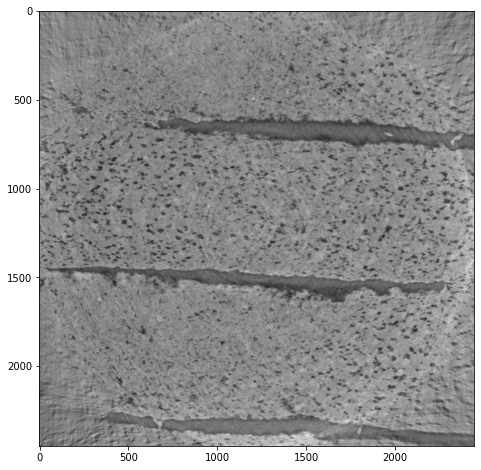

In [4]:
#Plot reconstructed slice
fig, ax = plt.subplots(1,1, figsize = (8,8))
#ax.imshow(Vrec_ubin_copy[100], cmap = 'gray')
ax.imshow(Vrec_ubin[100], cmap = 'gray')
plt.show()


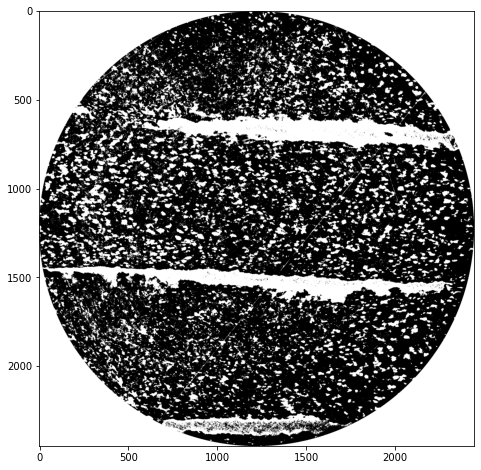

In [5]:
#Plot segmented slice
fig, ax = plt.subplots(1,1, figsize = (8,8))
ax.imshow(Vseg_ubin[100], cmap = 'gray')
plt.show()


<AxesSubplot:>

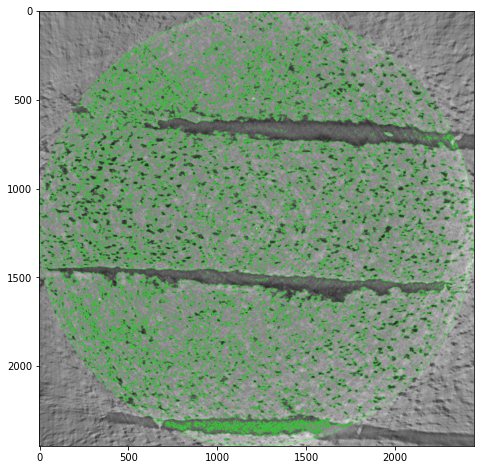

In [6]:
#Overlay plot
from tomo2mesh.misc import viewer
fig, ax = plt.subplots(1,1, figsize = (8,8))
#viewer.edge_plot(Vrec_ubin_copy[100],Vseg_ubin[100], ax)
viewer.edge_plot(Vrec_ubin[100],Vseg_ubin[100], ax)
